In [1]:
# ===============================
# STEP 1: Install dependencies
# ===============================
!pip install librosa soundfile tensorflow scikit-learn matplotlib seaborn


import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# ===============================
# STEP 2: Download dataset (RAVDESS)
# ===============================
# RAVDESS dataset (~700MB). If too big, switch to TESS/EMO-DB.

!wget -q --show-progress https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
!unzip -q Audio_Speech_Actors_01-24.zip -d ravdess


Audio_Speech_Actors 100%[===================>] 198.81M  13.8MB/s    in 17s     
replace ravdess/Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


🔍 Extracting MFCCs: 100%|██████████| 1440/1440 [02:43<00:00,  8.82it/s]


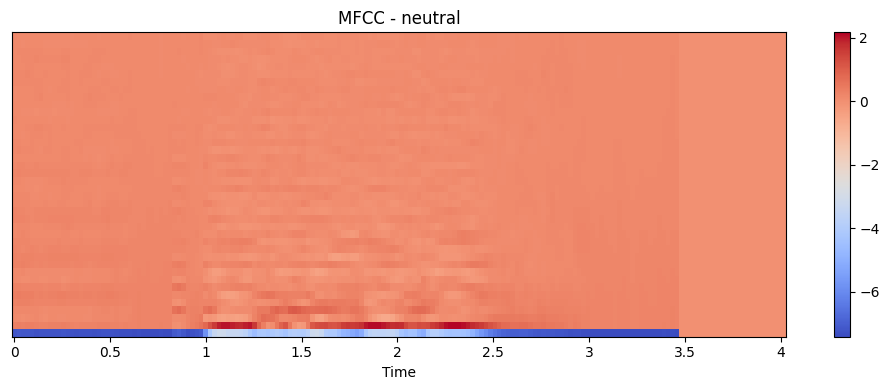

✅ Features extracted: 1440


In [5]:
# step 3
from tqdm import tqdm  # Progress bar

# Emotion label mapping
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

data = []
labels = []

# Feature extraction function
def extract_features(file_path, max_pad_len=174):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        audio, _ = librosa.effects.trim(audio)  # Optional: remove silence
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs = (mfccs - np.mean(mfccs)) / np.std(mfccs)  # Normalize
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        return mfccs
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None

# Collect all .wav file paths
file_paths = []
for dirpath, _, filenames in os.walk("ravdess/"):
    for file in filenames:
        if file.endswith(".wav"):
            file_paths.append(os.path.join(dirpath, file))

# Extract features with progress bar
for file_path in tqdm(file_paths, desc="🔍 Extracting MFCCs"):
    emotion_code = file_path.split("/")[-1].split("-")[2]
    emotion = emotions.get(emotion_code)
    feature = extract_features(file_path)
    if feature is not None:
        data.append(feature)
        labels.append(emotion)

# Visualize one sample
plt.figure(figsize=(10, 4))
librosa.display.specshow(data[0], x_axis='time')
plt.colorbar()
plt.title(f'MFCC - {labels[0]}')
plt.tight_layout()
plt.show()

print("✅ Features extracted:", len(data))


In [6]:
# ===============================
# STEP 4: Prepare Dataset
# ===============================
X = np.array(data)
y = np.array(labels)

# Encode labels
encoder = LabelEncoder()
y = to_categorical(encoder.fit_transform(y))

# Reshape for CNN input
X = X[..., np.newaxis]   # (n_samples, 40, 174, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


X_train: (1152, 40, 174, 1)
y_train: (1152, 8)


In [7]:
# ===============================
# STEP 5: Build CNN Model
# ===============================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(40,174,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 172, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,752,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,772,488 (10.58 MB)

 Trainable params: 2,772,488 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ===============================
# STEP 6: Train Model
# ===============================
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=30,
                    batch_size=32,
                    verbose=1)


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step - accuracy: 0.1981 - loss: 2.0170 - val_accuracy: 0.2165 - val_loss: 1.8533
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step - accuracy: 0.3176 - loss: 1.7587 - val_accuracy: 0.3030 - val_loss: 1.7498
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 445ms/step - accuracy: 0.4335 - loss: 1.5822 - val_accuracy: 0.3636 - val_loss: 1.5864
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 328ms/step - accuracy: 0.4960 - loss: 1.3457 - val_accuracy: 0.3939 - val_loss: 1.6204
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 295ms/step - accuracy: 0.5489 - loss: 1.2147 - val_accuracy: 0.4156 - val_loss: 1.5399
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - accuracy: 0.6764 - loss: 0.9586 - val_accuracy: 0.4502 - val_loss: 1.5580
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - accuracy: 0.7383 - loss: 0.7701 - val_accuracy: 0.4675 - val_loss: 1.4700
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step - accuracy: 0.7775 - loss: 0.6329 - val_accura

🎯 Test Accuracy: 0.5590277910232544
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step


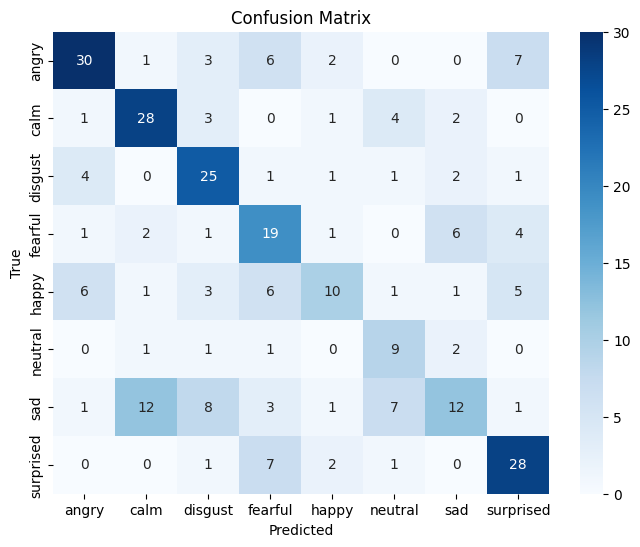

              precision    recall  f1-score   support

       angry       0.70      0.61      0.65        49
        calm       0.62      0.72      0.67        39
     disgust       0.56      0.71      0.62        35
     fearful       0.44      0.56      0.49        34
       happy       0.56      0.30      0.39        33
     neutral       0.39      0.64      0.49        14
         sad       0.48      0.27      0.34        45
   surprised       0.61      0.72      0.66        39

    accuracy                           0.56       288
   macro avg       0.54      0.57      0.54       288
weighted avg       0.56      0.56      0.55       288



In [9]:
# ===============================
# STEP 7: Evaluate Model
# ===============================
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("🎯 Test Accuracy:", test_acc)

# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))


In [10]:
# ===============================
# STEP 8: Try Prediction on New Audio
# ===============================
def predict_emotion(file_path):
    feature = extract_features(file_path)
    feature = feature[np.newaxis, ..., np.newaxis]
    prediction = model.predict(feature)
    emotion = encoder.inverse_transform([np.argmax(prediction)])
    return emotion[0]

# Example test
sample_file = "ravdess/Actor_01/03-01-03-01-01-01-01.wav"
print("Predicted Emotion:", predict_emotion(sample_file))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Predicted Emotion: happy


In [13]:
# Another test sample
sample_file = "ravdess/Actor_02/03-01-06-01-01-02-02.wav"  # Emotion code '05' = angry
print("Predicted Emotion:", predict_emotion(sample_file))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted Emotion: fearful


In [12]:
import pickle

# Save model
model.save("emotion_cnn_model.h5")

# Save label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)
